In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
svi_df = pd.read_csv('../../data/svi.csv')
svi_df.head()

,FID,GEOID10,AREA_SQFT,AREA_ACRES,POP100_RE,HU100_RE,TotDis,TotChild,OlderAdult,Low_to_No,LEP,POC2,MedIllnes,Name,Shape__Area,Shape__Length
0,1,25025010405,3914567.54,89.8661,5522,994,470,60,331,1191,1522,1755,2131.22,Mission Hill,666100.000000,6036.192907
1,2,25025010404,1472713.92,33.8089,5817,1862,299,77,56,2387,2443,1749,2201.14,Fenway,250612.382812,2176.592171
2,3,25025010801,1376667.12,31.6039,2783,1899,84,281,390,72,462,447,1214.76,Back Bay,234357.910156,2542.043078
3,4,25025010702,3228780.12,74.1226,2400,1643,45,86,285,187,472,320,1014.20,Back Bay,549614.007812,3224.573044
4,5,25025010204,2741497.18,62.9361,3173,1283,131,13,36,895,931,1039,1181.78,Fenway,466585.238281,3143.610637


In [3]:
file_names = ['../../data/2011.csv', '../../data/2012.csv', '../../data/2013.csv', '../../data/2014.csv', '../../data/2015.csv', 
              '../../data/2016.csv', '../../data/2017.csv', '../../data/2018.csv', '../../data/2019.csv', '../../data/2020.csv',
              '../../data/2021.csv', '../../data/2022.csv', '../../data/2023.csv']

# Read the data from the CSV files into a list of DataFrames to be combined and filter the first row of all of the files except the first one
data_list = []

for file in file_names:
    data = pd.read_csv(file,low_memory=False)
    data_list.append(data)

# Concatenate the DataFrames
df = pd.concat(data_list, ignore_index=True)


In [4]:
df = df[['on_time', 'open_dt', 'closed_dt', 'case_status', 'neighborhood', 'type', 'source']]
merged_df = pd.merge(df, svi_df, left_on='neighborhood', right_on='Name', how='left')

# Convert dates to datetime
merged_df['open_dt'] = pd.to_datetime(merged_df['open_dt'])
merged_df['closed_dt'] = pd.to_datetime(merged_df['closed_dt'])

# Calculate time to close
merged_df['time_to_close'] = (merged_df['closed_dt'] - merged_df['open_dt']).dt.total_seconds() / 3600  # in hours

# Group by neighborhood
grouped = merged_df.groupby('neighborhood')

# Calculate averages and percentages
neighborhood_stats = grouped.agg({
    'on_time': lambda x: (x == 'ONTIME').mean(),  # average percentage of on-time cases
    'time_to_close': 'mean',  # average time to close
    'case_status': lambda x: (x == 'Closed').mean(),  # percentage of closed cases
    'FID': 'first', 'GEOID10': 'first', 'AREA_SQFT': 'first', 'AREA_ACRES': 'first',
    'POP100_RE': 'first', 'HU100_RE': 'first', 'TotDis': 'first', 'TotChild': 'first',
    'OlderAdult': 'first', 'Low_to_No': 'first', 'LEP': 'first', 'POC2': 'first', 'MedIllnes': 'first'
})

# Rename columns for clarity
neighborhood_stats.rename(columns={
    'on_time': 'avg_pct_cases_closed_on_time',
    'time_to_close': 'avg_time_to_close',
    'case_status': 'avg_pct_cases_closed'
}, inplace=True)

neighborhood_stats = neighborhood_stats.dropna()

# Save to CSV
neighborhood_stats.to_csv('../../data/neighborhood_stats.csv', index=False)

In [5]:
neighborhood_stats_df = pd.read_csv('../../data/neighborhood_stats.csv')
neighborhood_stats_df.head()

,avg_pct_cases_closed_on_time,avg_time_to_close,avg_pct_cases_closed,FID,GEOID10,AREA_SQFT,AREA_ACRES,POP100_RE,HU100_RE,TotDis,TotChild,OlderAdult,Low_to_No,LEP,POC2,MedIllnes
0,0.779260,1031.228195,0.903192,8.0,2.502500e+10,1916064.65,43.9868,2791.0,1418.0,99.0,31.0,31.0,1740.0,1771.0,1083.0,1029.60
1,0.795245,849.709274,0.934282,3.0,2.502501e+10,1376667.12,31.6039,2783.0,1899.0,84.0,281.0,390.0,72.0,462.0,447.0,1214.76
2,0.801888,913.472325,0.917409,9.0,2.502500e+10,3586159.72,82.3269,4985.0,2726.0,700.0,35.0,837.0,1967.0,2804.0,1123.0,2113.60
3,0.774695,922.003885,0.931955,96.0,2.502504e+10,2791324.87,64.0800,2168.0,1239.0,141.0,322.0,290.0,214.0,504.0,116.0,917.28
4,0.812933,593.002377,0.930253,25.0,2.502510e+10,5947564.59,136.5373,5154.0,2192.0,450.0,1006.0,429.0,841.0,1270.0,3052.0,1878.33


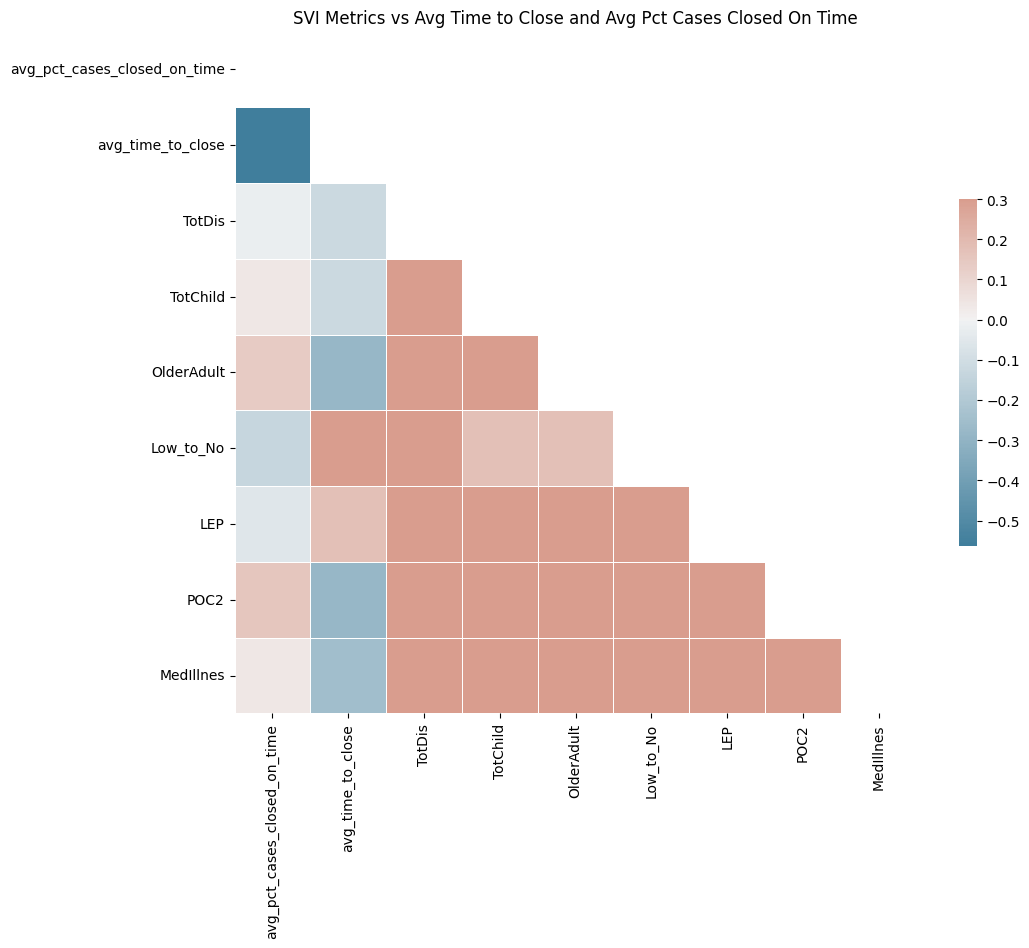

In [ ]:
correlation_columns = [
    'avg_pct_cases_closed_on_time',
    'avg_time_to_close',
    'TotDis', 'TotChild', 'OlderAdult', 'Low_to_No',
    'LEP', 'POC2', 'MedIllnes'
]

# Creating a subset of the dataframe with the selected columns
correlation_df = neighborhood_stats_df[correlation_columns]

# Calculating the correlation matrix
correlation_matrix = correlation_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("SVI Metrics vs Avg Time to Close and Avg Pct Cases Closed On Time")
plt.show()

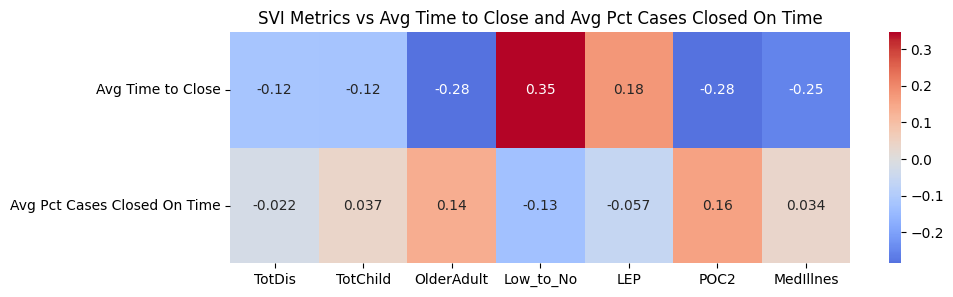

In [ ]:
# Extracting correlations of SVI metrics with 'avg_time_to_close' and 'avg_pct_cases_closed_on_time'
svi_time_correlation = correlation_df.corr().loc['avg_time_to_close', 'TotDis':'MedIllnes']
svi_pct_closed_on_time_correlation = correlation_df.corr().loc['avg_pct_cases_closed_on_time', 'TotDis':'MedIllnes']

heatmap_df = pd.DataFrame([svi_time_correlation, svi_pct_closed_on_time_correlation])

# Renaming the index for clarity
heatmap_df.index = ['Avg Time to Close', 'Avg Pct Cases Closed On Time']

# Creating the heatmap
plt.figure(figsize=(10, 3))
sns.heatmap(heatmap_df, annot=True, cmap='coolwarm', center=0)
plt.title("SVI Metrics vs Avg Time to Close and Avg Pct Cases Closed On Time")
plt.show()